# Whats the Cause of your Power Outage?

**Name(s)**: Kaii Bijlani, Ketan Mittal

**Website Link**: https://k1mittal.github.io/Causes_of_Power_Outages/

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import scipy    
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, Binarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

### Interesting Questions:
- How does the cause of the power outages indicate other factors, for example, does whether related power outages result in more people having no power? Can we predict the cause of power outages?
- Is there a correlation between the time and other factors, do power outages happen in one month specifically? Has the number of power outages decreased over time? Can we predict when the next power outage is using a time series prediction?
- Can we predict the number of people affected by a power outage given certain factors? Are the number of people affected by power outages correlated to other factors?
- Can we predict the duration of power outages given certain factors? How are the duration of power outages correlated to other factors?

### Our Choice:
We decided to answer the first bullet point, which is what aspects of power outage are related to each category of cause. 

## Step 2: Data Cleaning and Exploratory Data Analysis

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

In [3]:
# Data Init and Cleanin
raw_data = pd.read_excel(Path('./outage.xlsx'))
raw_data.columns = [f'{raw_data.columns[i]}' for i in range(len(raw_data.columns))]
raw_data = raw_data.iloc[1:, 1:].loc[:, ['OBS', 'YEAR', 'MONTH', 'U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'TOTAL.REALGSP']]


Below we display the only missing values for outage start dates. Note how there are only 9 entries, and each of these entries also have missing relevant features. Therefore, imputation is not something of interest in this case and we can simply drop these values

In [4]:
raw_data = raw_data.dropna(subset = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'], how = 'any')

# Concatenates the time and date for both start and end
raw_data['OUTAGE.START'] = pd.to_datetime(
    raw_data['OUTAGE.START.DATE'].astype(str) + ' ' + raw_data['OUTAGE.START.TIME'].astype(str)
)

raw_data['OUTAGE.END'] = pd.to_datetime(
    raw_data['OUTAGE.RESTORATION.DATE'].astype(str) + ' ' + raw_data['OUTAGE.RESTORATION.TIME'].astype(str)
)
raw_data = raw_data.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])

raw_data['OUTAGE.START'].isna().sum()

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/845298299.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/845298299.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



np.int64(0)

#### Adding Seasons using Binning

We want to add a column indicating season for our later EDA and tests. Since month is already provided, we can use binning.

In [5]:
# Bins into seasons based on the month of the year
seasons = {'(0, 1]': 'Winter', '(1, 4]': 'Spring', '(4, 7]': 'Summer', '(7, 10]': 'Fall', '(10, 12]': 'Winter'}

raw_data['SEASONAL.BINS'] = pd.cut(raw_data['MONTH'], bins = [0, 1, 4, 7, 10, 12])
raw_data['SEASONAL.BINS'] = raw_data['SEASONAL.BINS'].astype(str).map(seasons)
raw_data

OBS    YEAR  MONTH    U.S._STATE NERC.REGION      CLIMATE.REGION  \
1        1.0  2011.0    7.0     Minnesota         MRO  East North Central   
2        2.0  2014.0    5.0     Minnesota         MRO  East North Central   
...      ...     ...    ...           ...         ...                 ...   
1532  1532.0  2009.0    8.0  South Dakota         RFC  West North Central   
1533  1533.0  2009.0    8.0  South Dakota         MRO  West North Central   

     ANOMALY.LEVEL      CAUSE.CATEGORY CLIMATE.CATEGORY CAUSE.CATEGORY.DETAIL  \
1             -0.3      severe weather           normal                   NaN   
2             -0.1  intentional attack           normal             vandalism   
...            ...                 ...              ...                   ...   
1532           0.5           islanding             warm                   NaN   
1533           0.5           islanding             warm                   NaN   

     OUTAGE.DURATION DEMAND.LOSS.MW  CUSTOMERS.AFFECTED TOTAL.PRICE  \
1               3060            NaN             70000.0        9.28   
2                  1            NaN                 NaN        9.28   
...              ...            ...                 ...         ...   
1532              59             84                 NaN        7.67   
1533             181            373                 NaN        7.67   

     TOTAL.SALES  TOTAL.CUSTOMERS TOTAL.REALGSP        OUTAGE.START  \
1        6562520         2.60e+06        274182 2011-07-01 17:00:00   
2        5284231         2.64e+06        291955 2014-05-11 18:38:00   
...          ...              ...           ...                 ...   
1532      924051         4.36e+05         36504 2009-08-29 22:54:00   
1533      924051         4.36e+05         36504 2009-08-29 11:00:00   

              OUTAGE.END SEASONAL.BINS  
1    2011-07-03 20:00:00        Summer  
2    2014-05-11 18:39:00        Summer  
...                  ...           ...  
1532 2009-08-29 23:53:00          Fall  
1533 2009-08-29 14:01:00          Fall  

[1476 rows x 20 columns]

#### Simple Handling of NaN Values

We will replace all 0 entries for `CUSTOMERS.AFFECTED` and `OUTAGE.DURATION` with `np.nan` for now, because a outage having 0 duration or 0 customers affected implies that it either is missing or was not an "actual" outage

In [6]:
# Sets all 0 values for customers affected and outage duration to np.nan for now, for our missingness tests. Note that these will need to be dealt with before feeding into our model (imputation or dropping)
raw_data.loc[raw_data['CUSTOMERS.AFFECTED'] == 0, 'CUSTOMERS.AFFECTED'] = np.nan
raw_data.loc[raw_data['OUTAGE.DURATION'] == 0, 'OUTAGE.DURATION'] = np.nan
print(raw_data.head().to_markdown(index=False))

|   OBS |   YEAR |   MONTH | U.S._STATE   | NERC.REGION   | CLIMATE.REGION     |   ANOMALY.LEVEL | CAUSE.CATEGORY     | CLIMATE.CATEGORY   | CAUSE.CATEGORY.DETAIL   |   OUTAGE.DURATION |   DEMAND.LOSS.MW |   CUSTOMERS.AFFECTED |   TOTAL.PRICE |   TOTAL.SALES |   TOTAL.CUSTOMERS |   TOTAL.REALGSP | OUTAGE.START        | OUTAGE.END          | SEASONAL.BINS   |
|------:|-------:|--------:|:-------------|:--------------|:-------------------|----------------:|:-------------------|:-------------------|:------------------------|------------------:|-----------------:|---------------------:|--------------:|--------------:|------------------:|----------------:|:--------------------|:--------------------|:----------------|
|     1 |   2011 |       7 | Minnesota    | MRO           | East North Central |            -0.3 | severe weather     | normal             | nan                     |              3060 |              nan |                70000 |          9.28 |       6562520 |       2.5957e+06 

### EDA

#### Univariate Analysis

We start by displaying the distributions of observations by cause to see how our data is distributed

In [7]:
# Displays the probability density histogram of observations by cause
cause_pdf = px.histogram(raw_data, x = 'CAUSE.CATEGORY', title = 'Distributions of Observations by Cause', histnorm = 'probability density')
cause_pdf.show()

Next, we will see the distribution of observations by state. We will use `Folium` as a tool to geospacially visualize this distribution.

In [8]:
# Gets the JSON object describing the geospatial data (longitude, latitude, etc) of states in the U.S.
states_url = f'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json'

# Distribution of observation by state
states_data = raw_data['U.S._STATE'].value_counts().reset_index(drop = False)
states_data

U.S._STATE  count
0     California    198
1          Texas    122
..           ...    ...
47  South Dakota      2
48  North Dakota      1

[49 rows x 2 columns]

In [9]:
# Creates a frequency map using Folium
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4) # Centered on the US
folium.Choropleth(
    geo_data=states_url, 
    name='State Frequency',
    data=states_data, 
    columns=['U.S._STATE', 'count'], 
    key_on='feature.properties.name', 
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2, 
    legend_name='Frequency'
).add_to(m)
m

In [10]:
raw_data

OBS    YEAR  MONTH    U.S._STATE NERC.REGION      CLIMATE.REGION  \
1        1.0  2011.0    7.0     Minnesota         MRO  East North Central   
2        2.0  2014.0    5.0     Minnesota         MRO  East North Central   
...      ...     ...    ...           ...         ...                 ...   
1532  1532.0  2009.0    8.0  South Dakota         RFC  West North Central   
1533  1533.0  2009.0    8.0  South Dakota         MRO  West North Central   

     ANOMALY.LEVEL      CAUSE.CATEGORY CLIMATE.CATEGORY CAUSE.CATEGORY.DETAIL  \
1             -0.3      severe weather           normal                   NaN   
2             -0.1  intentional attack           normal             vandalism   
...            ...                 ...              ...                   ...   
1532           0.5           islanding             warm                   NaN   
1533           0.5           islanding             warm                   NaN   

     OUTAGE.DURATION DEMAND.LOSS.MW  CUSTOMERS.AFFECTED TOTAL.PRICE  \
1               3060            NaN             70000.0        9.28   
2                  1            NaN                 NaN        9.28   
...              ...            ...                 ...         ...   
1532              59             84                 NaN        7.67   
1533             181            373                 NaN        7.67   

     TOTAL.SALES  TOTAL.CUSTOMERS TOTAL.REALGSP        OUTAGE.START  \
1        6562520         2.60e+06        274182 2011-07-01 17:00:00   
2        5284231         2.64e+06        291955 2014-05-11 18:38:00   
...          ...              ...           ...                 ...   
1532      924051         4.36e+05         36504 2009-08-29 22:54:00   
1533      924051         4.36e+05         36504 2009-08-29 11:00:00   

              OUTAGE.END SEASONAL.BINS  
1    2011-07-03 20:00:00        Summer  
2    2014-05-11 18:39:00        Summer  
...                  ...           ...  
1532 2009-08-29 23:53:00          Fall  
1533 2009-08-29 14:01:00          Fall  

[1476 rows x 20 columns]

### Bivariate Analysis

We start by display a violin plot (summary statistics) by season

In [11]:
# Violin plot of anomaly level by season
duration_customers_plt = px.violin(raw_data, x = 'SEASONAL.BINS', y = 'ANOMALY.LEVEL', color = "SEASONAL.BINS")
duration_customers_plt.update_layout(legend_title = 'Seasons', title = 'Violin Plot of Anomaly Level by Season')
duration_customers_plt.show()

In [12]:
# Scatter of duration by climate region
region_duration_plt = px.scatter(raw_data, x = 'CLIMATE.REGION', y = 'OUTAGE.DURATION')
region_duration_plt.update_layout(title = 'Scatterplot of Duration by Climate Region')

In [13]:
# Pivot table describing the mean of total prices, for each climate region for each cause category
price_climate_cause = raw_data.pivot_table(index = 'CAUSE.CATEGORY', columns = 'CLIMATE.REGION', values = 'TOTAL.PRICE', aggfunc = 'mean')
price_climate_cause

CLIMATE.REGION                Central East North Central Northeast Northwest  \
CAUSE.CATEGORY                                                                 
equipment failure                7.65               7.92     12.35       6.9   
fuel supply emergency            7.44              10.51     16.03      7.29   
...                               ...                ...       ...       ...   
severe weather                   8.27               9.34     12.45      6.83   
system operability disruption     8.4               8.24     13.71      6.32   

CLIMATE.REGION                South Southeast Southwest   West  \
CAUSE.CATEGORY                                                   
equipment failure              8.24     10.15      8.07  12.74   
fuel supply emergency          9.17       NaN      8.65  13.82   
...                             ...       ...       ...    ...   
severe weather                 8.63      8.36      8.13  12.79   
system operability disruption  8.66      9.11      8.68  12.37   

CLIMATE.REGION                West North Central  
CAUSE.CATEGORY                                    
equipment failure                           6.21  
fuel supply emergency                        NaN  
...                                          ...  
severe weather                              6.37  
system operability disruption                NaN  

[7 rows x 9 columns]

## Step 3: Assessment of Missingness

### Part 3.1: Missingness Mechanism Analysis
If we look at our feature of interest, we can see that approximately 30 percent of values are missing. This is most likely not MCAR and requires more analysis to see if its missingness depends on other features.

In [14]:
raw_data[['CAUSE.CATEGORY.DETAIL']]

CAUSE.CATEGORY.DETAIL
1                      NaN
2                vandalism
...                    ...
1532                   NaN
1533                   NaN

[1476 rows x 1 columns]

In [15]:
raw_data['CAUSE.CATEGORY.DETAIL'].isna().mean()

np.float64(0.3035230352303523)

In [16]:
raw_data[['CAUSE.CATEGORY.DETAIL', 'CAUSE.CATEGORY']]

CAUSE.CATEGORY.DETAIL      CAUSE.CATEGORY
1                      NaN      severe weather
2                vandalism  intentional attack
...                    ...                 ...
1532                   NaN           islanding
1533                   NaN           islanding

[1476 rows x 2 columns]

In [17]:
''' This cell defines valid, relevant test statistics for permutation and 
hypothesis tests.
'''
def tvd(dist1: pd.Series, dist2: pd.Series):
    return (dist1.value_counts(normalize = True) - dist2.value_counts(normalize = True)).abs().sum() / 2

def ks(dist1: pd.Series, dist2: pd.Series):
    return scipy.stats.ks_2samp(dist1, dist2).statistic

In [18]:
''' This function takes in a dataframe, a column with missing values and a 
column to analyze the type of missingness mechanism with. It will return
a p-value and an associative True or False indicating if missing_col is MAR 
withrespect to col. To conduct the permutation test, it will use the given 
test_stat.

The function will also graph the distribution of simulated test statistics 
with a line indicating where the observed lies.
'''
    
def identify_mar(df, missing_col, col, test_stat, N = 1000, alpha = 0.05, display = True):
    missing_dist = df[[col]].assign(is_missing = df[missing_col].isna()).dropna(subset = [col])
    observed = test_stat(missing_dist[missing_dist['is_missing']][col], missing_dist[~missing_dist['is_missing']][col])
    simulations = np.array([])
    for _ in range(N):
        missing_dist['is_missing'] = np.random.permutation(missing_dist['is_missing'])
        simulated = test_stat(missing_dist[missing_dist['is_missing']][col], missing_dist[~missing_dist['is_missing']][col])
        simulations = np.append(simulations, simulated)
    
    simulations = simulations[~np.isnan(simulations)]
    
    if display:
        fig = px.histogram(x = simulations, title = f'MAR Test of {missing_col} against {col}', labels={'x': 'Simulated Test Statistics'}, histnorm = 'probability')
        fig.add_vline(x=observed, line_color='red', line_width=2, annotation_text='Observed', annotation_position='top right')
        fig.show()    
        
    p_value = (simulations > observed).mean()
    return p_value, p_value < alpha

$H_0$: Cause category detail is MAR with respect to U.S. state

$H_a$: Cause category detail is not MAR with respect to U.S. state

We will perform a permutation test on missing (False or True) and using the TVD as the test statistic, since U.S. state is categorical.

In [19]:
p_val, is_mar = identify_mar(raw_data, 'CAUSE.CATEGORY.DETAIL', 'U.S._STATE', tvd, 1000, 0.05)
p_val, is_mar

(np.float64(0.0), np.True_)

$H_0$: Outage duration is MAR with respect to month

$H_a$: Outage duration is not MAR with respect to month

We will perform a permutation test on missing (False or True) and using the TVD as the test statistic, since month is also categorical.

In [20]:
p_val2, is_mar2 = identify_mar(raw_data, 'OUTAGE.DURATION', 'MONTH', tvd, 1000, 0.05)
p_val2, is_mar2

(np.float64(0.603), np.False_)

Clearly, there is evidence that the `CAUSE.CATEGORY.DETAIL_` column is **MAR** with respect to `CAUSE.CATEGORY_`. In other words, the missingness for cause category details are *highly* dependent on what the actual cause category is, which makes a lot of sense intuitively.

However, we conclude that `OUTAGE.DURATION` is not **MAR** with respect to `MONTH`, which also makes sense since the month shouldn't tell you the expected duration of an outage.

## Step 4: Hypothesis Testing

The first test we conduct is to see whether the proportion of each cause category is relatively reasonable. However, since this will differ widely for each observation, we will analyze its uniformness across *each season*

$H_0$: The proportion of each cause category is uniformly distributed across each season, for each cause category.

$H_a$: The proportion of each cause category is not uniformly distributed across each season, for each cause category.

To do this, we will calculate the TVD for each season (for each cause category), and aggregate the TVDs (using an agg function like `mean` or `sum`)

In [21]:
''' Calculates the TVD for 2D distributions across each column (axis = 0). 
The resulting TVD's will be aggregated (sum or mean) to represent the TVD of 
the whole distributions. Assumes the probability distributions are already
calculated and provided.
'''
def tvd_2d(dist1: pd.DataFrame, dist2: pd.DataFrame, aggfunc):
    return (np.sum(np.abs(dist1 - dist2), axis = 0) / 2).agg(aggfunc)

First we need to get the empirical distribution of cause category by season.

In [22]:
# Creates a pivot table of counts by season and cause category, and normalizes them across each season. This means that each season should have the sum of proportions equal to 1

seasonal_counts = raw_data.pivot_table(values = 'OBS', columns = 'SEASONAL.BINS', index = 'CAUSE.CATEGORY', aggfunc = 'size')

cause_totals = seasonal_counts.sum(axis = 0)
seasonal_totals = seasonal_counts.sum(axis = 1)
expected_proportions = seasonal_totals / seasonal_counts.sum().sum()

observed_dist = seasonal_counts / cause_totals
expected_dist = pd.DataFrame(data = {col: expected_proportions for col in observed_dist.columns})
observed_tvd = tvd_2d(expected_dist, observed_dist, 'sum')
observed_dist

SEASONAL.BINS                  Fall  Spring  Summer  Winter
CAUSE.CATEGORY                                             
equipment failure              0.02    0.05    0.05    0.03
fuel supply emergency          0.02    0.04    0.02    0.03
...                             ...     ...     ...     ...
severe weather                 0.57    0.40    0.51    0.53
system operability disruption  0.07    0.11    0.09    0.06

[7 rows x 4 columns]

In [23]:
# Perform a permutation test by recalculating the distribution after permuting the season. Then, calculate the '2D-TVD' test statistic we defined above, for each permutation.

NUM_SIMULATIONS = 1000
sim_season_df = raw_data[['SEASONAL.BINS', 'CAUSE.CATEGORY', 'OBS']]
simulations = []
for _ in range(NUM_SIMULATIONS):
    sim_season_df['SEASONAL.BINS'] = np.random.permutation(sim_season_df['SEASONAL.BINS'])
    sim_counts = sim_season_df.pivot_table(values = 'OBS', columns = 'SEASONAL.BINS', index = 'CAUSE.CATEGORY', aggfunc = 'size')

    sim_cause_totals = sim_counts.sum(axis = 0)
    sim_seasonal_totals = sim_counts.sum(axis = 1)
    sim_expected_proportions = sim_seasonal_totals / sim_counts.sum().sum()

    sim_observed_dist = sim_counts / sim_cause_totals
    sim_expected_dist = pd.DataFrame(data = {col: sim_expected_proportions for col in sim_observed_dist.columns})
    sim_tvd = tvd_2d(sim_expected_dist, sim_observed_dist, 'sum')
    
    simulations.append(sim_tvd)
simulations[:5]

[np.float64(0.08946597819818172),
 np.float64(0.15708773762010508),
 np.float64(0.15930685206943643),
 np.float64(0.12490741781511616),
 np.float64(0.09939371699527222)]

In [24]:
# Distribution of TVD for the permutation test
fig_hyp1 = px.histogram(simulations, histnorm = 'probability', title = 'Permutation Test Distribution of Cause Category by Season Distribution (TVD)')
fig_hyp1.add_vline(x=observed_tvd, line_color='red', line_width=2, annotation_text='Observed', annotation_position='top right')
fig_hyp1.update_layout(xaxis_title = 'TVD')
fig_hyp1.show()

In [25]:
p_val_hyp1 = (observed_tvd < simulations).mean()
p_val_hyp1

np.float64(0.0)

Therefore, since the p-value << 0.05 we reject the null, and there is evidence to prove that cause categories are not uniformly distributed across each season

### Test Number 2

$H_0$: The distributions of mean affected customers for each state is the same for observations from 2005 and 2006

$H_a$: The distributions of mean affected customers for each state is different for observations from 2005 and 2006

In [26]:
raw_data['YEAR'] = raw_data['YEAR'].astype(float)
customers_dist_2005 = raw_data[raw_data['YEAR'] == 2005.0][['U.S._STATE', 'CUSTOMERS.AFFECTED']].groupby('U.S._STATE').mean()
customers_dist_2005 /= customers_dist_2005.sum(axis = 0)
customers_dist_2005 = customers_dist_2005['CUSTOMERS.AFFECTED'].dropna()

customers_dist_2006 = raw_data[raw_data['YEAR'] == 2006.0][['U.S._STATE', 'CUSTOMERS.AFFECTED']].groupby('U.S._STATE').mean()
customers_dist_2006 /= customers_dist_2006.sum(axis = 0)
customers_dist_2006 = customers_dist_2006['CUSTOMERS.AFFECTED'].dropna()

observed_tvd_customers = np.abs(customers_dist_2006 - customers_dist_2005).sum() / 2
observed_tvd_customers


np.float64(0.1931225644342009)

In [27]:
N_CUSTOMERS = 1000
sim_customers_2006 = np.random.multinomial(N_CUSTOMERS, pvals = customers_dist_2005, size = 100_000) / N_CUSTOMERS
sim_tvds_customers = np.sum(np.abs(sim_customers_2006 - customers_dist_2005.to_numpy()), axis = 1) / 2
hist = px.histogram(sim_tvds_customers, histnorm = 'probability density').add_vline(x=observed_tvd_customers, line_color='red', line_width=2, annotation_text='Observed', annotation_position='top right')
hist.update_layout(xaxis_title = 'TVD')
hist.show()
sim_tvds_customers.mean(), sim_tvds_customers.std()

(np.float64(0.04379252328222323), np.float64(0.009265433556153432))

In [28]:
p_val_hyp2 = (np.array(sim_tvds_customers) >= observed_tvd_customers).mean()
p_val_hyp2

np.float64(0.0)

Therefore, we have evidence to reject the null and conclude that that distribution of mean affected customers is different for each state, for years 2005 and 2006

## Step 5: Framing a Prediction Problem

We plan to predict the cause column, which represents the general cause of power outages. Since this column contains categorical data, it is a classification problem. We will use features such as the number of people affected, outage duration, demand loss, and climatic conditions to build a predictive model. We aim to uncover patterns that help identify the causes of power outages based on their associated impacts and conditions. This will provide valuable insights for improving outage management and preparedness.

## Step 6: Baseline Model

In [29]:
# Drop irrelevant columns, and visualize the number of missing values
mdl_data = raw_data.drop(columns = ['CAUSE.CATEGORY.DETAIL', 'OUTAGE.START', 'OUTAGE.END', 'SEASONAL.BINS', 'NERC.REGION', 'OBS'])
mdl_data.isna().sum(axis = 0).sort_values(ascending=False)

DEMAND.LOSS.MW        672
CUSTOMERS.AFFECTED    622
                     ... 
TOTAL.CUSTOMERS         0
TOTAL.REALGSP           0
Length: 14, dtype: int64

Base model will just simply replace missing values with 0 or drop them, instead of imputing

In [30]:
# Fills missing values for demand loss, customers affected and outage duration with 0. Drops missing values for price, sales and climate region.
mdl_data[['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION']] = mdl_data[['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION']].fillna(0)
mdl_data.dropna(subset = ['TOTAL.PRICE', 'TOTAL.SALES', 'CLIMATE.REGION'], inplace = True)

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/4283828493.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Base model:

1. Data encoding
    1. One-hot encodes US states, climate region and climate category
    2. Ordinal encodes month
    3. Passes the remaining (numerical) columns as is
2. Passes encoded data into a random forest classifier

In [31]:
'''
Base model:
1. Data encoding
    1. One-hot encodes US states, climate region and climate category
    2. Ordinal encodes month
    3. Passes the remaining (numerical) columns as is
2. Passes encoded data into a random forest classifier
'''

mdl_base = Pipeline(steps = [
    ('data_encoding', ColumnTransformer(transformers = [
        ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['U.S._STATE', 'CLIMATE.REGION', 'CLIMATE.CATEGORY']),
        ('ordinal', OrdinalEncoder(), ['MONTH']),
    ], remainder = 'passthrough')),
    ('random_forest', RandomForestClassifier())
])

In [32]:
# Separates into y and X. Since we are predicting cause category, we use that as y. All other relevant features are X

X = mdl_data.drop(columns = ['CAUSE.CATEGORY'])
y = mdl_data['CAUSE.CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y)

mdl_data.isna().sum(axis = 0).sort_values(ascending=False)

YEAR               0
MONTH              0
                  ..
TOTAL.CUSTOMERS    0
TOTAL.REALGSP      0
Length: 14, dtype: int64

In [33]:
mdl_base.fit(X_train, y_train)

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('data_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['U.S._STATE',
                                                   'CLIMATE.REGION',
                                                   'CLIMATE.CATEGORY']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['MONTH'])])),
                ('random_forest', RandomForestClassifier())])

In [34]:
# Indicates that our model is likely overfitting, which makes sense without hyperparameter tuning
mdl_base.score(X_train, y_train)

1.0

In [35]:
# Pretty decent score for R^2 and f1, for the test set
y_base_preds = mdl_base.predict(X_test)
mdl_base.score(X_test, y_test), float(f1_score(y_test, y_base_preds, average = 'macro'))

(0.821917808219178, 0.6394880722268838)

In [36]:
# Precision and recall for the test set
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_base_preds, average = 'macro'), recall_score(y_test, y_base_preds, average = 'macro')

(np.float64(0.6944759197211223), np.float64(0.6264345159481938))

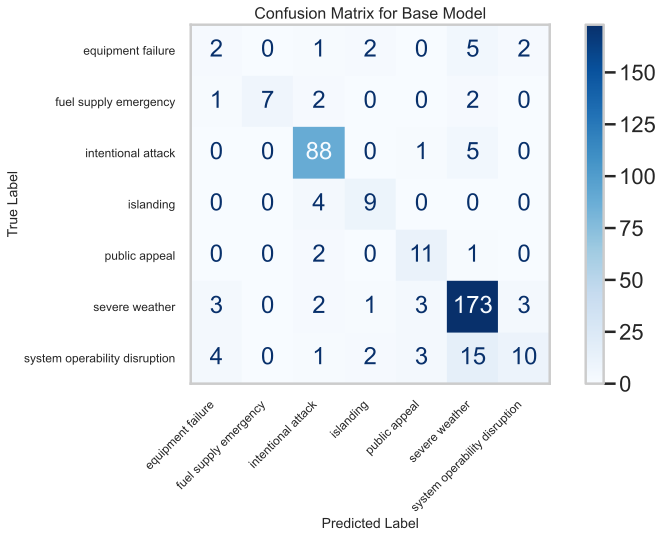

In [37]:
# Plots the confusion matrix with true label on the Y and predicted on the X
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_estimator(
    mdl_base, X_test, y_test, ax=ax, cmap="Blues", colorbar=True
)

plt.title("Confusion Matrix for Base Model", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45, ha="right")

plt.yticks(fontsize=12)
plt.grid(False)

plt.tight_layout()
plt.show()

## Step 7: Final Model

We now define model 2:

1. Data encoding
    1. One hot encode US state, climate region and climate category
    2. Ordinal encode month, since it has inherent order to it
    3. Pass rest of (numerical) features through
2. Pass encoded data through random forest classifier
    1. Perform grid search (GridSearchCV) for the random forest criterion, max depth and number of estimators to tune hyperparameters 

In [38]:
from sklearn.model_selection import GridSearchCV

params_1 = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': np.arange(5, 25), 'n_estimators': [5, 10, 20, 50, 100, 200]}

mdl_1 = Pipeline(steps = [
    ('data_encoding', ColumnTransformer(transformers = [
        ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['U.S._STATE', 'CLIMATE.REGION', 'CLIMATE.CATEGORY']),
        ('ordinal', OrdinalEncoder(), ['MONTH']),
    ], remainder = 'passthrough')),
    ('gscv', GridSearchCV(RandomForestClassifier(), param_grid = params_1, cv = 5))
])

In [39]:
mdl_1.fit(X_train, y_train)

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('data_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['U.S._STATE',
                                                   'CLIMATE.REGION',
                                                   'CLIMATE.CATEGORY']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['MONTH'])])),
                ('gscv',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy',
                                                        'log_loss'],
                                          'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24]),
                                          'n_estimators': [5, 10, 20, 50, 100,
                                                           200]}))])

In [40]:
# Test R^2 score and f1_score for model 1
y_1_preds = mdl_1.predict(X_test)
mdl_1.score(X_test, y_test), f1_score(y_test, y_1_preds, average = 'macro') 

(0.821917808219178, np.float64(0.6356607562893146))

We can see that our model is marginally better than our base, but by a small amount. We can still improve.

In [41]:
# Precision and recall for model 1
precision_score(y_test, y_1_preds, average = 'macro'), recall_score(y_test, y_1_preds, average = 'macro')

(np.float64(0.7199547835328463), np.float64(0.6046658084652005))

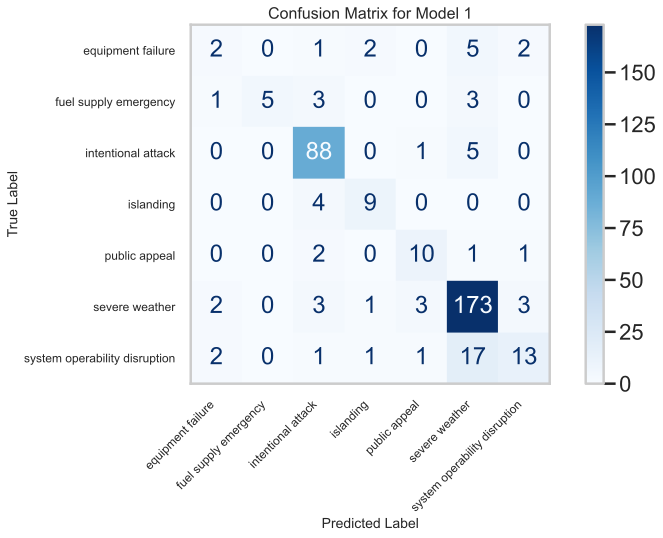

In [42]:
# Display confusion matrix for model 1
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_estimator(
    mdl_1, X_test, y_test, ax=ax, cmap="Blues", colorbar=True
)

plt.title("Confusion Matrix for Model 1", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45, ha="right")

plt.yticks(fontsize=12)
plt.grid(False)

plt.tight_layout()
plt.show()

Still could use improvement, so we look at the feature space $\mathbb(F)$ now

In [43]:
# Shows the amount of missing values for each feature
mdl_2_data = raw_data.copy().drop(columns = ['OBS', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.START', 'OUTAGE.END', 'SEASONAL.BINS'])
mdl_2_data.isna().sum(axis = 0).sort_values(ascending = False)

DEMAND.LOSS.MW        672
CUSTOMERS.AFFECTED    622
                     ... 
TOTAL.CUSTOMERS         0
TOTAL.REALGSP           0
Length: 15, dtype: int64

Since we have a lot of missing vaues for customers affected and demand loss, we can perform **MAR** tests on each other column for these two features. Based on our results, we can impute accordingly

In [44]:
# For each missing column, go through every other column and perform a MAR test for each. Store the result of each test in a tuple (col, p_value, is_mar) for each missing_col in a dictionary.

from collections import defaultdict
num_columns = ['YEAR', 'MONTH', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'TOTAL.REALGSP']
missing_cols = ['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED']
mar_status = defaultdict(lambda: [])
for missing_col in missing_cols:
    for col in num_columns:
        p_customers, is_mar_customers = identify_mar(mdl_2_data, missing_col, col, ks, alpha = 0.01, display = False)
        mar_status[missing_col].append((col, p_customers, is_mar_customers))

mar_status

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/2091289738.py:8: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/1247589762.py:27: RuntimeWarning:

Mean of empty slice.

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/2091289738.py:8: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/1247589762.py:27: RuntimeWarning:

Mean of empty slice.

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning:

invalid value encountered in scalar 

defaultdict(<function __main__.<lambda>()>,
            {'DEMAND.LOSS.MW': [('YEAR', np.float64(0.0), np.True_),
              ('MONTH', np.float64(0.082), np.False_),
              ('ANOMALY.LEVEL', np.float64(0.0), np.True_),
              ('OUTAGE.DURATION', np.float64(0.004), np.True_),
              ('DEMAND.LOSS.MW', np.float64(nan), np.False_),
              ('CUSTOMERS.AFFECTED', np.float64(0.0), np.True_),
              ('TOTAL.PRICE', np.float64(0.011), np.False_),
              ('TOTAL.SALES', np.float64(0.0), np.True_),
              ('TOTAL.CUSTOMERS', np.float64(0.0), np.True_),
              ('TOTAL.REALGSP', np.float64(0.0), np.True_)],
             'CUSTOMERS.AFFECTED': [('YEAR', np.float64(0.0), np.True_),
              ('MONTH', np.float64(0.0), np.True_),
              ('ANOMALY.LEVEL', np.float64(0.0), np.True_),
              ('OUTAGE.DURATION', np.float64(0.0), np.True_),
              ('DEMAND.LOSS.MW', np.float64(0.0), np.True_),
              ('CUSTOMERS.AFFEC

Now, we want to see how many columns are MAR vs not MAR with respect to the above two missing columns of interest.

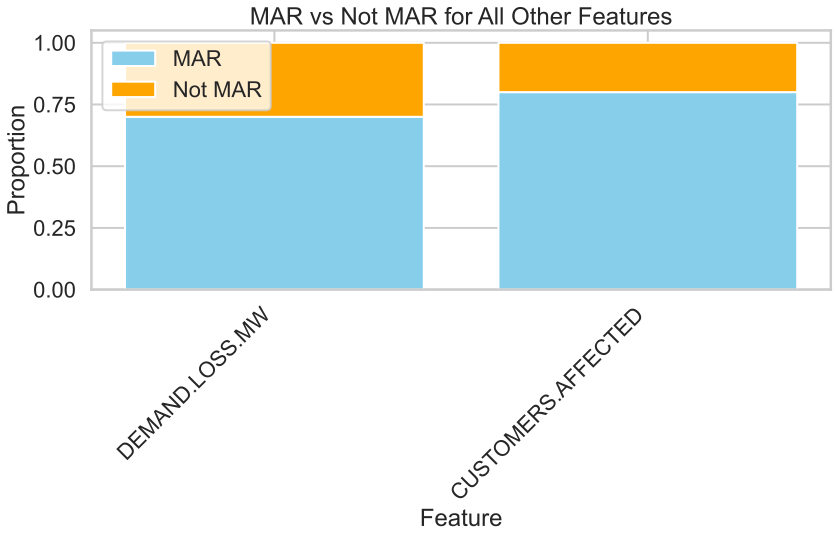

In [45]:
# This plot displays the proportion of MAR vs not MAR columns for each of the two columns of interest.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data = {'Feature': [], 'MAR': [], 'Not MAR': []}

for target_col, features in mar_status.items():
    mar_count = sum([1 for _, _, mar in features if mar])
    not_mar_count = len(features) - mar_count
    total = len(features)
    
    # Normalize to proportions
    data['Feature'].append(target_col)
    data['MAR'].append(mar_count / total)
    data['Not MAR'].append(not_mar_count / total)


df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(12, 8))  


ax.bar(df['Feature'], df['MAR'], label='MAR', color='skyblue')
ax.bar(df['Feature'], df['Not MAR'], bottom=df['MAR'], label='Not MAR', color='orange')


ax.set_xlabel('Feature')
ax.set_ylabel('Proportion')
ax.set_title('MAR vs Not MAR for All Other Features')
plt.xticks(rotation=45, ha="right")
ax.legend()


plt.tight_layout()
plt.show()

Since both `CUSTOMERS.AFFECTED` and `DEMAND.LOSS.MW` are shown to be **MAR** with respect to almost every other feature, we can impute these using techniques like K-Nearest Neighbors or Random Forest Regression

We are also using more features in this model version.

In [46]:
px.histogram(mdl_2_data['CUSTOMERS.AFFECTED'])

Note how the distribution of customers affected seems relatively normal until outliers stretch the distribution, so we can standardize to account for this difference and hopefully improve our model.

Model 2 (Final Model):

1. Data encoding
    1. One-hot encodes US states, climate region, climate category and NERC region
    2. Ordinal encodes month
    3. Standardizes the customers affected, as this is expected to follow a relatively normal distribution
    3. Passes the remaining (numerical) columns as is
2. Passes encoded data into an iterative imputer
    1. Uses random forest regression to impute missing values based on the provided encoded features. Note that encoding goes before this step, since random forest only works on numerical features (or encoded categorical)|
3. Pass encoded AND imputed data through a random forest classifier
    1. Perform grid search (GridSearchCV) for the random forest criterion, max depth and number of estimators to tune hyperparameters 

In [58]:
'''
Model 2 (Final Model):

1. Data encoding
    1. One-hot encodes US states, climate region, climate category and NERC region
    2. Ordinal encodes month
    3. Standardizes the customers affected, as this is expected to follow a relatively normal distribution
    3. Passes the remaining (numerical) columns as is
2. Passes encoded data into an iterative imputer
    1. Uses random forest regression to impute missing values based on the provided encoded features. Note that encoding goes before this step, since random forest only works on numerical features (or encoded categorical)|
3. Pass encoded AND imputed data through a random forest classifier
    1. Perform grid search (GridSearchCV) for the random forest criterion, max depth and number of estimators to tune hyperparameters 
'''
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

params_1 = {
    'criterion': ['entropy'], 
    'max_depth': np.arange(5, 25), 
    'n_estimators': [5, 10, 20, 50, 100, 200]
}

mdl_2 = Pipeline(steps=[
    ('data_encoding', ColumnTransformer(
        transformers=[
            ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output = False), ['U.S._STATE', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'NERC.REGION']),
            ('ordinal', OrdinalEncoder(), ['MONTH']),
            ('standard', StandardScaler(), ['CUSTOMERS.AFFECTED'])
        ], remainder='passthrough')
    ),
    ('imputer', IterativeImputer(
        estimator=RandomForestRegressor(), 
        max_iter=10, random_state=0 
    )),
    ('gscv', GridSearchCV(RandomForestClassifier(), param_grid=params_1, cv=5))
])

In [59]:
# Splits into train and test again since we are using more features this time
y_2 = mdl_2_data['CAUSE.CATEGORY']
X_2 = mdl_2_data.drop(columns = ['CAUSE.CATEGORY'])
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2)

In [60]:
mdl_2.fit(X_2_train, y_2_train)

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('data_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['U.S._STATE',
                                                   'CLIMATE.REGION',
                                                   'CLIMATE.CATEGORY',
                                                   'NERC.REGION']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['MONTH']),
                                                 ('standard', StandardScaler(),
                                                  ['CUSTOMERS.AFFECTED'])])),
                ('imputer',
                 IterativeImputer(estimator=RandomForestRegressor(),
                                  random_state=0)),
                ('gscv',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['entropy'],
                                          'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24]),
                                          'n_estimators': [5, 10, 20, 50, 100,
                                                           200]}))])

In [61]:
# Train score on this version of the model
mdl_2.score(X_2_train, y_2_train)

1.0

In [ ]:
# R^2 test score and f1 score for this model
y_2_preds = mdl_2.predict(X_2_test)
mdl_2.score(X_2_test, y_2_test), f1_score(y_2_test, y_2_preds, average = 'macro')


This test score is MUCH better! This indicates that this version of our model is the best out of what we developed so far.

In [ ]:
# Also has high precision and recall, indicating low bias towards one category or the other.
precision_score(y_2_test, y_2_preds, average = 'macro'), recall_score(y_2_test, y_2_preds, average = 'macro')

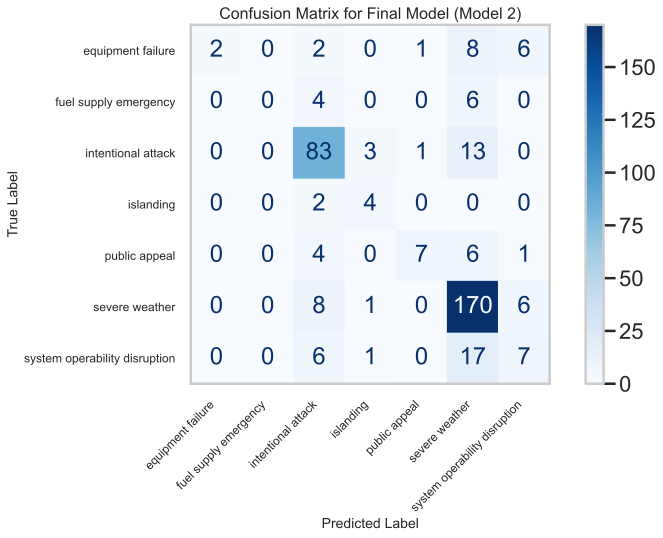

In [53]:
# Visualizes confusion matrix for this model
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_estimator(
    mdl_2, X_2_test, y_2_test, ax=ax, cmap="Blues", colorbar=True
)

plt.title("Confusion Matrix for Final Model (Model 2)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45, ha="right")

plt.yticks(fontsize=12)
plt.grid(False)

plt.tight_layout()
plt.show()

## Step 8: Fairness Analysis

We are going to analyze the f1_scores for high vs low electricity consuming outages. This is a relevant feature to analyze since it indicates whether or model is performing fairly for both types of outages, indicating high availability.

In [54]:
# Actual and predicted test values stored in a df
final_mdl_results = pd.DataFrame(data = {'Actual': y_2_test, 'Predicted': y_2_preds})
final_mdl_results

Actual           Predicted
181      severe weather      severe weather
86       severe weather      severe weather
..                  ...                 ...
878  intentional attack  intentional attack
329      severe weather      severe weather

[369 rows x 2 columns]

In [55]:
total_sales = X_2_test[['TOTAL.SALES']]
px.histogram(total_sales)

Based on the above plot, we can choose 18,000,000 as a relevant Binarizer threshold. Values above this will be classified as 1 (high nationwide electricity consumption for the given outage) or 0 (high nationwide electricity consumption for the given outage)

In [56]:
bin = Binarizer(threshold = 18_000_000)
final_mdl_results['Group'] = bin.transform(total_sales.fillna(0))
final_mdl_results

/var/folders/1m/hjhr1x894h35cktycnd3vr_m0000gn/T/ipykernel_43360/2143724488.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/ketan/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but Binarizer was fitted without feature names



Actual           Predicted  Group
181      severe weather      severe weather      1
86       severe weather      severe weather      0
..                  ...                 ...    ...
878  intentional attack  intentional attack      0
329      severe weather      severe weather      0

[369 rows x 3 columns]

$H_0$: The model is fair for both high electricity consumption outages and low electricity consumption outages.

$H_a$: The model is unfair for both high electricity consumption outages and low electricity consumption outages.

We will use the absolute difference in `f1_score` for low outages (group 0) and high outages (group 1). A high test statistic would indicate that our model favors one or the opter (i.e. its predictions are much different for those in group 0 versus those in group 1)

In [57]:
# Performs a permutation test, using abs difference in f1_score as the test statistic. Permutes and groups by both groups (high or low consumption)
obs_fair = abs(f1_score(final_mdl_results[final_mdl_results['Group'] == 0]['Actual'], final_mdl_results[final_mdl_results['Group'] == 0]['Predicted'], average = 'macro') - f1_score(final_mdl_results[final_mdl_results['Group'] == 1]['Actual'], final_mdl_results[final_mdl_results['Group'] == 1]['Predicted'], average = 'macro'))

fairness_sim = np.array([])

for _ in range(1000):
    final_mdl_results['Shuffled'] = np.random.permutation(final_mdl_results['Group'])
    sim = abs(f1_score(final_mdl_results[final_mdl_results['Shuffled'] == 0]['Actual'], final_mdl_results[final_mdl_results['Shuffled'] == 0]['Predicted'], average = 'macro') - f1_score(final_mdl_results[final_mdl_results['Shuffled'] == 1]['Actual'], final_mdl_results[final_mdl_results['Shuffled'] == 1]['Predicted'], average = 'macro'))
    fairness_sim = np.append(fairness_sim, sim)
    
p_val_fair = (fairness_sim > obs_fair).mean()

fig_fair = px.histogram(fairness_sim, title = 'Absoulte Difference in f1-score for High vs Low National Electricy Consuming Outages')
fig_fair.add_vline(x=obs_fair, line_color='red', line_width=2, annotation_text='Observed', annotation_position='top right')
fig_fair.show()
p_val_fair

np.float64(0.643)

With a p-value of 0.262 >> 0.05, we can conclude that there is significant evidence that our model is fair for both low and high electricity consuming outages.